## How to use the t-SNE algorithm on APOGEE globular cluster data. 
##### Steffani Grondin (September 23, 2022)

#### STEP 0: Import the necessary packages/algorithms.

In [1]:
# General analysis/plotting packages:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from collections import Counter

# Specific t-SNE/visualization packages:
from sklearn.manifold import TSNE
from shapely.geometry import Point, Polygon

#### STEP 1: Load in the M3 datafile. 

This example uses APOGEE DR17 data (https://www.sdss.org/dr17/) with astroNN chemical abundances (https://astronn.readthedocs.io/en/latest/) and includes all stars that are within a 10x10 degree field of view around M3's centre.

In [2]:
M3 = pd.read_csv('../tsne_umap_tutorials/data/M3data_10x10.csv', delimiter=',')

# Spatial:
ra = M3["ra"]   #APOGEE
dec = M3["dec"]   #APOGEE

# Identification:
apogee_ID = M3["apogee_ID"]   #APOGEE
gaia_ID = M3["gaia_ID"]  # Gaia

# Kinematic:
parallax = M3["parallax"]  # Gaia
pmra = M3["pmra"]  # Gaia
pmra_err = M3["pmra_err"]  # Gaia
pmdec = M3["pmdec"]  # Gaia
pmdec_err = M3["pmdec_err"]  # Gaia
RV = M3["RV"]   #APOGEE
RV_err = M3["RV_err"]   #APOGEE
dist = M3["dist"]   #APOGEE
dist_err = M3["dist_err"]   #APOGEE
jr = M3["jr"]   #APOGEE
jr_err = M3["jr_err"]   #APOGEE
jz = M3["jz"]   #APOGEE
jz_err = M3["jz_err"]   #APOGEE
jphi = M3["jphi"]   #APOGEE
jphi_err = M3["jphi_err"]    #APOGEE

# Spectral (useful for filtering):
TEFF_ERR = M3["TEFF_err"]   #APOGEE
TEFF = M3["TEFF"]   #APOGEE
LOGG_ERR = M3["LOGG_err"]   #APOGEE
LOGG = M3["LOGG"]   #APOGEE
SNR = M3["SNR"]   #APOGEE

# Chemical abundances from astroNN:
FE_H = M3['FEH'] 
C_FE = M3['CFE']
CI_FE = M3['CIFE']
N_FE = M3['NFE']
O_FE = M3['OFE']
MG_FE = M3['MGFE']
AL_FE = M3['ALFE']
SI_FE = M3['SIFE']
P_FE = M3['PFE']
S_FE = M3['SFE']
K_FE = M3['KFE']
CA_FE = M3['CAFE']
TI_FE = M3['TIFE']
TIII_FE = M3['TIIIFE']
V_FE = M3['VFE']
CR_FE = M3['CRFE']
MN_FE = M3['MNFE']
CO_FE = M3['COFE']
NI_FE = M3['NIFE']

# Chemical abundance errors from astroNN:
FE_H_err = M3["FEH_err"] 
C_FE_err = M3['CFE_err']
CI_FE_err = M3['CIFE_err']
N_FE_err = M3['NFE_err']
O_FE_err = M3['OFE_err']
MG_FE_err = M3['MGFE_err']
AL_FE_err = M3['ALFE_err']
SI_FE_err = M3['SIFE_err']
P_FE_err = M3['PFE_err']
S_FE_err = M3['SFE_err']
K_FE_err = M3['KFE_err']
CA_FE_err = M3['CAFE_err']
TI_FE_err = M3['TIFE_err']
TIII_FE_err = M3['TIIIFE_err']
V_FE_err = M3['VFE_err']
CR_FE_err = M3['CRFE_err']
MN_FE_err = M3['MNFE_err']
CO_FE_err = M3['COFE_err']
NI_FE_err = M3['NIFE_err']

# Number of stars in the initial sample of APOGEE DR16: 
print("There are {} stars in our initial sample".format(len(ra)))

cols = [ra, dec, apogee_ID, gaia_ID, parallax, pmra, pmra_err, pmdec, pmdec_err, RV, RV_err, dist, dist_err,
        jr, jr_err, jphi, jphi_err, jz, jz_err, TEFF, TEFF_ERR, LOGG, LOGG_ERR, SNR, FE_H, FE_H_err, C_FE, 
        C_FE_err, CI_FE, CI_FE_err, N_FE, N_FE_err, O_FE, O_FE_err, MG_FE, MG_FE_err, AL_FE, AL_FE_err, SI_FE,
        SI_FE_err, P_FE, P_FE_err, S_FE, S_FE_err, K_FE, K_FE_err, CA_FE, CA_FE_err, TI_FE, TI_FE_err, TIII_FE,
        TIII_FE_err, V_FE, V_FE_err, CR_FE, CR_FE_err, MN_FE, MN_FE_err, CO_FE, CO_FE_err, NI_FE, NI_FE_err]

There are 5289 stars in our initial sample


#### STEP 2: Filter the data. 

First, we remove all stars without proper motions and chemical abundances for all 19 elements. Next, for stars with multiple spectra, we select the one with the highest SNR to represent the source. Finally, we remove all stars with low signal-to-noise (SNR) ratios. 

In [3]:
### Filter 1: Remove stars that do not have proper motion values. ###
pm_filter_nan = np.isnan(pmra)
pm_filter = np.where(pm_filter_nan==False)
data_pmfilter = []
for i in cols:
    x = np.array(i)[pm_filter]
    data_pmfilter.append(x)
print("There are {} stars in our sample after the proper motion filtering.".format(len(data_pmfilter[0])))

### Filter 2: Remove stars that do not have data for all 19 abundances. ###
abundance_filter = np.where((data_pmfilter[24] > -9999) & (data_pmfilter[26] > -9999) & (data_pmfilter[28]  > -9999)
                            & (data_pmfilter[30]  > -9999) & (data_pmfilter[32]  > -9999) & (data_pmfilter[34]  > -9999)
                            & (data_pmfilter[36]  > -9999) & (data_pmfilter[38]  > -9999) & (data_pmfilter[40]  > -9999)
                            & (data_pmfilter[42]  > -9999) & (data_pmfilter[44]  > -9999) & (data_pmfilter[46]  > -9999)
                            & (data_pmfilter[48]  > -9999) & (data_pmfilter[50]  > -9999) & (data_pmfilter[52]  > -9999)
                            & (data_pmfilter[54]  > -9999) & (data_pmfilter[56]  > -9999) & (data_pmfilter[58]  > -9999)
                            & (data_pmfilter[60]  > -9999))

data_abundancefilter = []
for i in data_pmfilter:
    y = np.array(i)[abundance_filter]
    data_abundancefilter.append(y)
print("There are {} stars in our sample after the abundance filtering.".format(len(data_abundancefilter[0])))

### Filter 3: Remove all duplicate spectra (i.e. select spectra with highest SNR for multiple measurements). ###
d =  Counter(data_abundancefilter[0])
duplicates = [k for k, v in d.items() if v > 1]
a_list = np.array(range(0, len(duplicates)))
max_SNR_array = []

for i in a_list:
    indices = np.where(data_abundancefilter[0] == duplicates[i])
    snr_val = data_abundancefilter[23][indices]
    maximum = max(snr_val)
    index_maximum = np.where((data_abundancefilter[0] == duplicates[i]) & (data_abundancefilter[23] == maximum))
    index_maximum = int(index_maximum[0])
    max_SNR_array.append(index_maximum)

idx_sort = np.argsort(data_abundancefilter[0])
sorted_ra_array = data_abundancefilter[0][idx_sort]
vals, idx_start, count = np.unique(sorted_ra_array, return_counts=True, return_index=True)
res = np.split(idx_sort, idx_start[1:])
vals = vals[count == 1]
listtest =  np.array(range(0, len(vals)))

unique_array = []
for i in listtest:
    unique_val = np.where(vals[i] == data_abundancefilter[0])
    unique_val = int(unique_val[0])
    unique_array.append(unique_val)
    
#print("There are {} stars that do not have duplicate spectra.".format(len(unique_array)))
#print("There are {} stars that have multiple spectra, in which we select highest SNR.".format(len(max_SNR_array)))

duplicates_filter = np.concatenate((unique_array, max_SNR_array))
sortedarray = np.sort(duplicates_filter)

data_duplicatesfilter = []
for i in data_abundancefilter:
    z = np.array(i)[duplicates_filter]
    data_duplicatesfilter.append(z)

print("There are {} stars in our sample after removing sources with duplicate spectra.".format(len(data_duplicatesfilter[0])))

### Filter 4: Remove all stars with low SNR. ###
SNR_filter = np.where(data_duplicatesfilter[23] > 50)
data_snrfilter = []
for i in data_duplicatesfilter:
    a = np.array(i)[SNR_filter]
    data_snrfilter.append(a)

print("There are {} stars in our sample after removing sources with low SNR.".format(len(data_snrfilter[0])))

There are 5240 stars in our sample after the proper motion filtering.
There are 5053 stars in our sample after the abundance filtering.
There are 3309 stars in our sample after removing sources with duplicate spectra.
There are 3212 stars in our sample after removing sources with low SNR.


#### ***CHECK-IN: Now that your data has been reduced, do some exploratory data analysis to see what the sample looks like!*

What parameters are in this file? What parameters might be useful to connect extra-tidal stars with a suspected birth cluster?

In [4]:
len(data_snrfilter)

62

In [5]:
data_snrfilter[0].shape

(3212,)

(Text(0.5, 0, 'RA'), Text(0, 0.5, 'N/FE'))

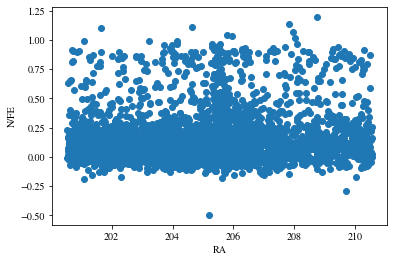

In [6]:
plt.scatter(data_snrfilter[M3.columns.get_loc("ra")], data_snrfilter[M3.columns.get_loc("NFE")])
plt.xlabel('RA'), plt.ylabel('N/FE')

FEH mean abundance: -0.4871550578345268
CFE mean abundance: 0.015488004095733811
CIFE mean abundance: -0.05208233335069116
NFE mean abundance: 0.17535234372426833
OFE mean abundance: 0.1171588853912058
MGFE mean abundance: 0.10901940288601836
ALFE mean abundance: 0.05650091164475794
SIFE mean abundance: 0.07101632365310087
PFE mean abundance: 0.23372374685152553
SFE mean abundance: 0.037611174814049186
KFE mean abundance: 0.0869068294299421
CAFE mean abundance: 0.09865593645453051
TIFE mean abundance: -0.037410882625295766
TIIIFE mean abundance: 0.004994864872230138
VFE mean abundance: -0.08543622528436208
CRFE mean abundance: 0.014401353075709836
MNFE mean abundance: -0.06743956197908779
COFE mean abundance: -0.16998276197438014
NIFE mean abundance: 0.042885845873536735


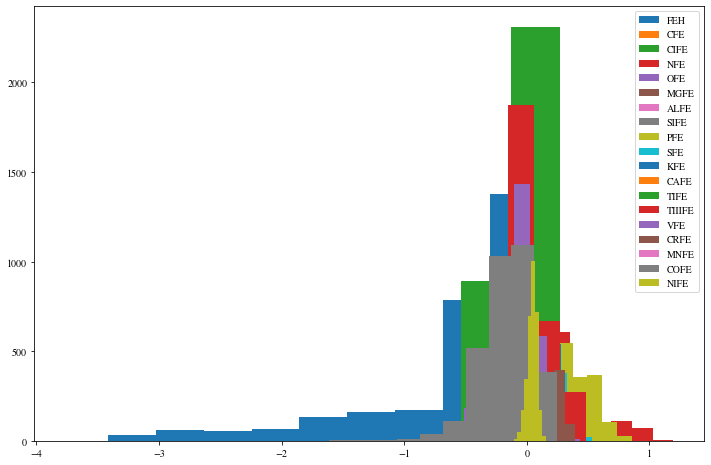

In [7]:
abundance_params = [column for column in M3.columns if 'FE' in column and not '_err' in column]
plt.figure(figsize = (12, 8))
for param in abundance_params:
    plt.hist(data_snrfilter[M3.columns.get_loc(param)], label = param)  # plot
    print(param + f" mean abundance: {np.mean(data_snrfilter[M3.columns.get_loc(param)])}")
plt.legend()

(array([1.000e+00, 5.000e+00, 6.670e+02, 1.451e+03, 6.060e+02, 1.940e+02,
        9.400e+01, 1.120e+02, 7.500e+01, 7.000e+00]),
 array([-0.49465266, -0.32568012, -0.15670759,  0.01226495,  0.18123748,
         0.35021002,  0.51918256,  0.68815509,  0.85712763,  1.02610016,
         1.1950727 ]),
 <BarContainer object of 10 artists>)

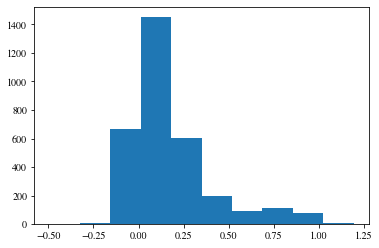

In [8]:
plt.hist(data_snrfilter[M3.columns.get_loc("NFE")])

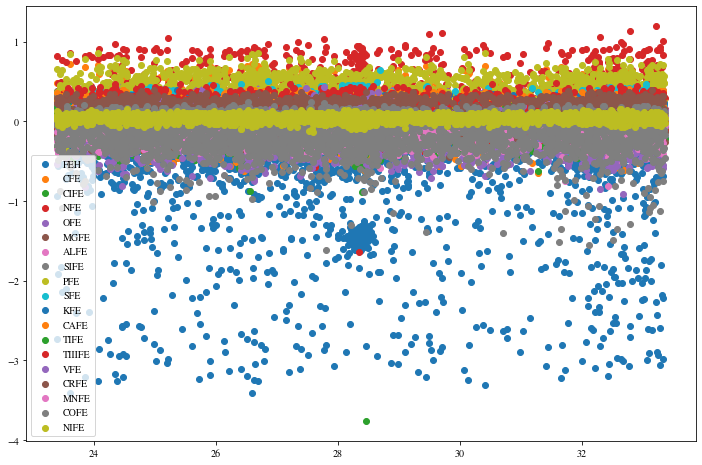

In [9]:
plt.figure(figsize = (12, 8))
for param in abundance_params:
    plt.scatter(data_snrfilter[M3.columns.get_loc("dec")], data_snrfilter[M3.columns.get_loc(param)], label = param)
plt.legend()

(Text(0.5, 0, 'Dec'), Text(0, 0.5, 'N/FE'))

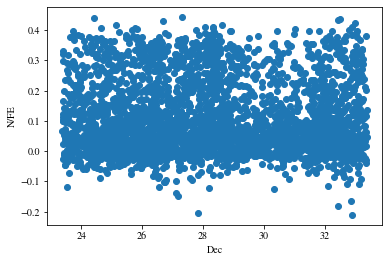

In [10]:
plt.scatter(data_snrfilter[M3.columns.get_loc("dec")], data_snrfilter[M3.columns.get_loc("OFE")])
plt.xlabel('Dec'), plt.ylabel('N/FE')

-18.727364640722605

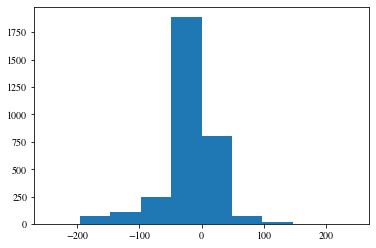

In [11]:
plt.hist(data_snrfilter[M3.columns.get_loc("RV")])
np.mean(data_snrfilter[M3.columns.get_loc("RV")])

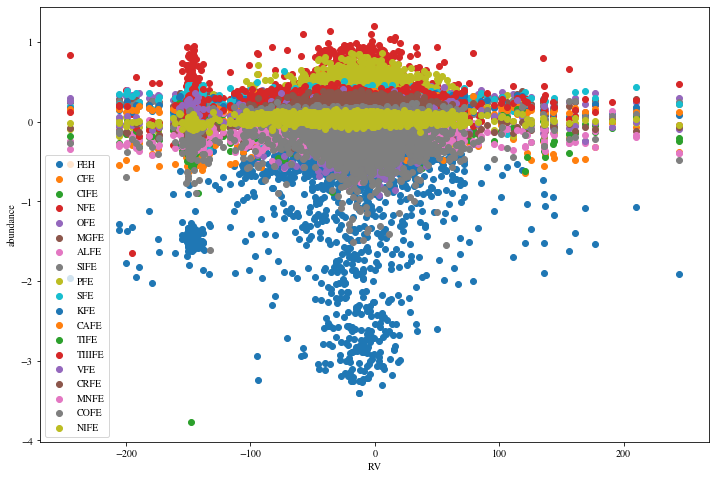

In [12]:
plt.figure(figsize = (12, 8))
for param in abundance_params:
    plt.scatter(data_snrfilter[M3.columns.get_loc("RV")], data_snrfilter[M3.columns.get_loc(param)], label = param)
plt.xlabel('RV'), plt.ylabel('abundance')
plt.legend()

In [13]:
abundance_params

['FEH',
 'CFE',
 'CIFE',
 'NFE',
 'OFE',
 'MGFE',
 'ALFE',
 'SIFE',
 'PFE',
 'SFE',
 'KFE',
 'CAFE',
 'TIFE',
 'TIIIFE',
 'VFE',
 'CRFE',
 'MNFE',
 'COFE',
 'NIFE']

In [14]:
list(M3.columns)

['ra',
 'dec',
 'apogee_ID',
 'gaia_ID',
 'parallax',
 'pmra',
 'pmra_err',
 'pmdec',
 'pmdec_err',
 'RV',
 'RV_err',
 'dist',
 'dist_err',
 'jr',
 'jr_err',
 'jphi',
 'jphi_err',
 'jz',
 'jz_err',
 'TEFF',
 'TEFF_err',
 'LOGG',
 'LOGG_err',
 'SNR',
 'FEH',
 'FEH_err',
 'CFE',
 'CFE_err',
 'CIFE',
 'CIFE_err',
 'NFE',
 'NFE_err',
 'OFE',
 'OFE_err',
 'MGFE',
 'MGFE_err',
 'ALFE',
 'ALFE_err',
 'SIFE',
 'SIFE_err',
 'PFE',
 'PFE_err',
 'SFE',
 'SFE_err',
 'KFE',
 'KFE_err',
 'CAFE',
 'CAFE_err',
 'TIFE',
 'TIFE_err',
 'TIIIFE',
 'TIIIFE_err',
 'VFE',
 'VFE_err',
 'CRFE',
 'CRFE_err',
 'MNFE',
 'MNFE_err',
 'COFE',
 'COFE_err',
 'NIFE',
 'NIFE_err']

#### STEP 3: Define parameters for your GC of interest. 

These parameters are taken from the Baumgardt & Hilker (2018) catalogue: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/.

In [15]:
ra_M3 = 205.548  # [deg]
dec_M3 = 28.3772  # [deg]
dist_M3 = 10180  # [pc]
rt_M3 = 159.0339  # [pc] -- tidal radius @ apogalacticon
rhm_M3 = 6.34  # [pc]
rhm_M3_deg = math.degrees(math.atan(rhm_M3 / dist_M3))  # deg
pmra_M3 = -0.152  # [mas/yr]
pmdec_M3 = -2.670  # [mas/yr]

#### STEP 4: Define a control group of cluster members.

We must define a control group of likely cluster members of M3 so we can see where these stars end up in the t-SNE projection. 

In [16]:
# Select all the stars within some radius of the cluster:
def in_circle(center_x, center_y, radius, x, y):
    square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
    return square_dist <= (radius) ** 2

ra_filtered = data_snrfilter[0]
dec_filtered = data_snrfilter[1]

# Select stars within 8 * r,hm (useful for large enough sample of probable cluster members):
in_halfmass = in_circle(ra_M3, dec_M3, 4*rhm_M3_deg, ra_filtered, dec_filtered)
indices_control = np.where(in_halfmass==True)

controlgroup = []
for i in data_snrfilter:
    b = np.array(i)[indices_control]
    controlgroup.append(b)

# Example control group parameters: 
ra_control = controlgroup[0]
dec_control = controlgroup[1]

print("There are {} stars in our M3 control group.".format(len(ra_control)))

There are 72 stars in our M3 control group.


FEH mean abundance: -1.4237357393055554
CFE mean abundance: -0.34161354868055555
CIFE mean abundance: -0.18531779751388885
NFE mean abundance: 0.4603883753333333
OFE mean abundance: 0.3001264343879167
MGFE mean abundance: 0.23280856666666663
ALFE mean abundance: 0.0029396772722222212
SIFE mean abundance: 0.21383160907708335
PFE mean abundance: -0.03499555475972222
SFE mean abundance: 0.3083535995833333
KFE mean abundance: 0.1624365333611111
CAFE mean abundance: 0.1376841507638889
TIFE mean abundance: -0.10376751628152778
TIIIFE mean abundance: 0.1328754880138889
VFE mean abundance: 0.01824529105
CRFE mean abundance: -0.12644661359722223
MNFE mean abundance: -0.26741158837500006
COFE mean abundance: -0.24036800518472223
NIFE mean abundance: -0.026932671749583335


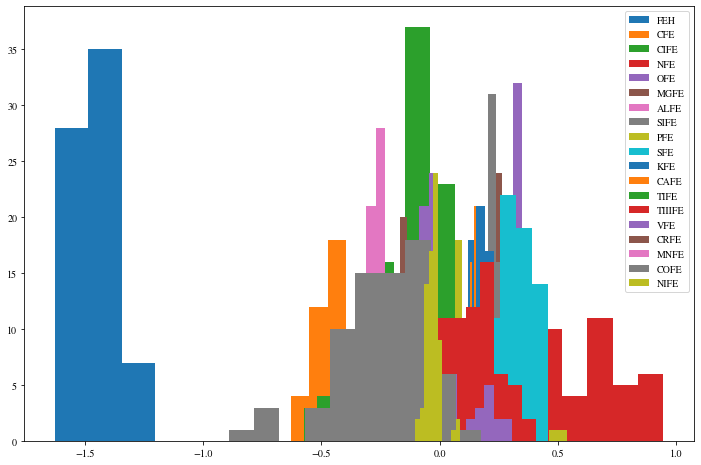

In [17]:
abundance_params = [column for column in M3.columns if 'FE' in column and not '_err' in column]
plt.figure(figsize = (12, 8))
for param in abundance_params:
    plt.hist(controlgroup[M3.columns.get_loc(param)], label = param)  # plot
    print(param + f" mean abundance: {np.mean(controlgroup[M3.columns.get_loc(param)])}")
plt.legend()

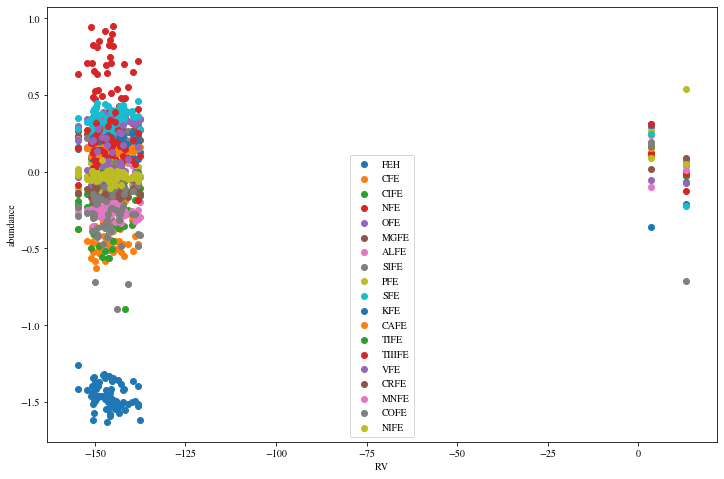

In [18]:
plt.figure(figsize = (12, 8))
for param in abundance_params:
    plt.scatter(controlgroup[M3.columns.get_loc("RV")], controlgroup[M3.columns.get_loc(param)], label = param)
plt.xlabel('RV'), plt.ylabel('abundance')
plt.legend()

#### ***CHECK-IN: Add this control group to your above exploratory plots.* 

What do you notice about these stars? What changes if you adjust the control group radius (i.e. what if you go larger or smaller than 8*r,hm)?


#### STEP 5: Run t-SNE on the control group and full filtered sample of APOGEE DR17 stars.

First, we standardize the data to ensure that no elements dominate or skew the t-SNE run. We want to include 19 chemical abundances and radial velocities in our run.  

In [26]:
FE_H_filtered, C_FE_filtered, CI_FE_filtered = data_snrfilter[24], data_snrfilter[26], data_snrfilter[28]
N_FE_filtered, O_FE_filtered, MG_FE_filtered = data_snrfilter[30], data_snrfilter[32], data_snrfilter[34]
AL_FE_filtered, SI_FE_filtered, P_FE_filtered = data_snrfilter[36], data_snrfilter[38], data_snrfilter[40]
S_FE_filtered, K_FE_filtered, CA_FE_filtered = data_snrfilter[42], data_snrfilter[44], data_snrfilter[46]
TI_FE_filtered, TIII_FE_filtered, V_FE_filtered = data_snrfilter[48], data_snrfilter[50], data_snrfilter[52]
CR_FE_filtered, MN_FE_filtered, CO_FE_filtered, NI_FE_filtered = data_snrfilter[54], data_snrfilter[56], data_snrfilter[58], data_snrfilter[60]
RV_filtered  = data_snrfilter[9]

pretsne_array = np.array([FE_H_filtered, C_FE_filtered, CI_FE_filtered, N_FE_filtered, O_FE_filtered, MG_FE_filtered,
                      AL_FE_filtered, SI_FE_filtered, P_FE_filtered, S_FE_filtered, K_FE_filtered, CA_FE_filtered, 
                      TI_FE_filtered, TIII_FE_filtered, V_FE_filtered, CR_FE_filtered, MN_FE_filtered, CO_FE_filtered,
                       NI_FE_filtered, RV_filtered])

standardized_array = []
for i in pretsne_array:
    mean, sigma = np.mean(i), np.std(i)
    norm = (i - mean) / sigma
    standardized_array.append(norm)

Next, we apply the t-SNE algorithm via scikit-learn to reduce the dimensionality of the data from 20-D to 2-D.

In [27]:
# Transpose the standardized + filtered array:
standardized_array_transpose = np.transpose(standardized_array)

# Run t-SNE on the transposed array:
tsne_init = TSNE(n_components=2, perplexity=30, early_exaggeration=12, learning_rate=200, init='random')
tsne_2d = tsne_init.fit_transform(standardized_array_transpose)

# Get t-SNE outputs for complete filtered dataset:
t_SNE_dimX = tsne_2d[:, 0]
t_SNE_dimY = tsne_2d[:, 1]

# Get t-SNE outputs for control group:
tsne_dimX_control = t_SNE_dimX[indices_control]
tsne_dimY_control = t_SNE_dimY[indices_control]

Finally, we plot the 2-D t-SNE projection. 

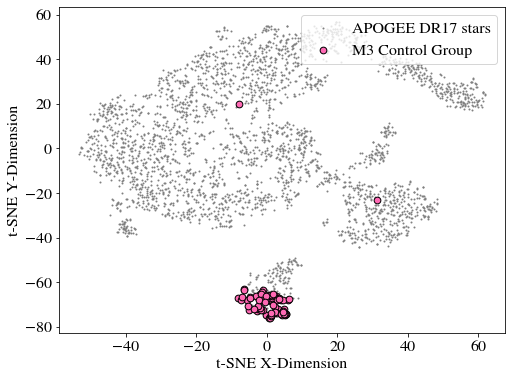

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(t_SNE_dimX, t_SNE_dimY, s=1, c='gray', label='APOGEE DR17 stars')
ax.scatter(tsne_dimX_control , tsne_dimY_control, s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
ax.set_xlabel("t-SNE X-Dimension", fontsize=16)
ax.set_ylabel("t-SNE Y-Dimension", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.legend(fontsize=16, loc=1)
plt.show()

## UMAP stuff:

In [29]:
import umap.umap_ as umap

# Try using SKLEARN's StandardScaler to standardize the data
from sklearn.preprocessing import StandardScaler

In [30]:
reducer = umap.UMAP(n_neighbors=15)
reducer.fit(standardized_array_transpose)
embedding = reducer.transform(standardized_array_transpose)

# Get t-SNE outputs for complete filtered dataset:
umap_dimX = embedding[:, 0]
umap_dimY = embedding[:, 1]

# Get t-SNE outputs for control group:
umap_dimX_control = umap_dimX[indices_control]
umap_dimY_control = umap_dimY[indices_control]

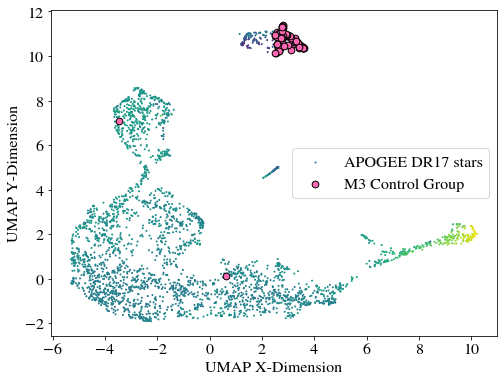

In [31]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(umap_dimX, umap_dimY, s=1, c=C_FE_filtered, label='APOGEE DR17 stars')
ax.scatter(umap_dimX_control , umap_dimY_control, s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
ax.set_xlabel("UMAP X-Dimension", fontsize=16)
ax.set_ylabel("UMAP Y-Dimension", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
# fig.colorbar(fig, cax=ax)
ax.legend(fontsize=16)
plt.show()

#### ***CHECK-IN: You succesfully ran t-SNE!*

What does this specific t-SNE projection actually tell you? How could you improve this t-SNE run? Importantly, how could you extend this method to find extra-tidal candidates of M3?

#### Improving the Dimensionality Reduction
Fine tune the hyper-parameters:
- understand how the different hyper-parameters affect the data
- what combination of hyper-parameters achieve the best separation of the control group? to acheive the best 

Helpful Papers:

https://distill.pub/2016/misread-tsne/ 

https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868 

Dimensional Reduction Astronomy Example:
https://arxiv.org/pdf/2210.02471.pdf


## Monte Carlo

For every point in the data set we draw new points from a normal distribution centered on that point with the standard deviation given by the error

In [19]:
np.random.seed(1234)  # set seed to test this

nsims = 1  # number of simulations to use for monte carlo, just use 1 for now
for j in range(0, nsims):
    # create copy of snrfilter
    monte_carlo_data = data_snrfilter.copy()
    # use all abundance parameters and rv since that's what our umap is based on:
    for param in abundance_params + ['RV']:
        # list of random points drawn using monte carlo for a given chemical abundance
        monte_carlo_points_param = np.array([np.random.normal(loc=data_snrfilter[M3.columns.get_loc(param)][i], scale=data_snrfilter[M3.columns.get_loc(param + '_err')][i], size=1) for i in range(0, len(data_snrfilter[M3.columns.get_loc(param)]))]).reshape(-1)
        # replace data in monte_carlo_data with the random points drawn using monte carlo
        monte_carlo_data[M3.columns.get_loc(param)] = monte_carlo_points_param
    

Create the pre-UMAP/t-SNE array:

In [20]:
FE_H_filtered, C_FE_filtered, CI_FE_filtered = monte_carlo_data[24], monte_carlo_data[26], monte_carlo_data[28]
N_FE_filtered, O_FE_filtered, MG_FE_filtered = monte_carlo_data[30], monte_carlo_data[32], monte_carlo_data[34]
AL_FE_filtered, SI_FE_filtered, P_FE_filtered = monte_carlo_data[36], monte_carlo_data[38], monte_carlo_data[40]
S_FE_filtered, K_FE_filtered, CA_FE_filtered = monte_carlo_data[42], monte_carlo_data[44], monte_carlo_data[46]
TI_FE_filtered, TIII_FE_filtered, V_FE_filtered = monte_carlo_data[48], monte_carlo_data[50], monte_carlo_data[52]
CR_FE_filtered, MN_FE_filtered, CO_FE_filtered, NI_FE_filtered = monte_carlo_data[54], monte_carlo_data[56], monte_carlo_data[58], monte_carlo_data[60]
RV_filtered  = monte_carlo_data[9]

# create array of all the abundances and also RV

preumaptsne_array = np.array([FE_H_filtered, C_FE_filtered, CI_FE_filtered, N_FE_filtered, O_FE_filtered, MG_FE_filtered,
                      AL_FE_filtered, SI_FE_filtered, P_FE_filtered, S_FE_filtered, K_FE_filtered, CA_FE_filtered, 
                      TI_FE_filtered, TIII_FE_filtered, V_FE_filtered, CR_FE_filtered, MN_FE_filtered, CO_FE_filtered,
                       NI_FE_filtered, RV_filtered])

# create standardized umap array

# standardized_umap_array = StandardScaler().fit_transform(preumaptsne_array)

# create standardized tsne array

standardized_tsne_array = []
for i in preumaptsne_array:
    mean, sigma = np.mean(i), np.std(i)
    norm = (i - mean) / sigma
    standardized_tsne_array.append(norm)

In [21]:
standardized_array[0], standardized_tsne_array[0]

NameError: name 'standardized_array' is not defined

In [22]:
plt.hist(standardized_array[0])
plt.hist(standardized_tsne_array[0])

NameError: name 'standardized_array' is not defined

Now run UMAP:

In [24]:
import umap.umap_ as umap

# Transpose the standardized + filtered array:
standardized_umap_array_transpose = np.transpose(standardized_tsne_array)

# Run UMAP on the transposed array:
reducer2 = umap.UMAP(n_neighbors=15)
reducer2.fit(standardized_umap_array_transpose)
embedding2 = reducer2.transform(standardized_umap_array_transpose)

# Get UMAP outputs for complete filtered dataset:
umap_dimX = embedding2[:, 0]
umap_dimY = embedding2[:, 1]

# Get UMAP outputs for control group:
umap_dimX_control = umap_dimX[indices_control]
umap_dimY_control = umap_dimY[indices_control]

Now run t-SNE:

In [91]:
# Transpose the standardized + filtered array:
standardized_tsne_array_transpose = np.transpose(standardized_tsne_array)

# Run t-SNE on the transposed array:
tsne_init = TSNE(n_components=2, perplexity=30, early_exaggeration=12, learning_rate=200, init='random')
tsne_2d = tsne_init.fit_transform(standardized_tsne_array_transpose)

# Get t-SNE outputs for complete filtered dataset:
t_SNE_dimX = tsne_2d[:, 0]
t_SNE_dimY = tsne_2d[:, 1]

# Get t-SNE outputs for control group:
tsne_dimX_control = t_SNE_dimX[indices_control]
tsne_dimY_control = t_SNE_dimY[indices_control]

Plotting both:

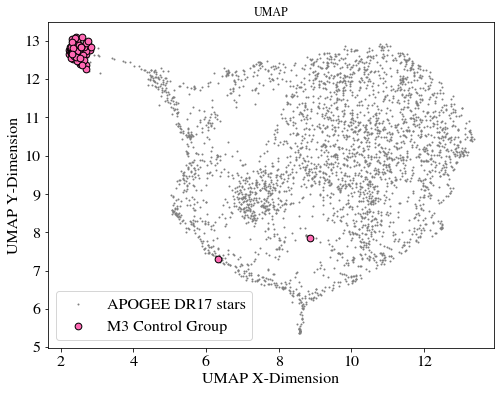

In [25]:
# plotting UMAP:

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(umap_dimX, umap_dimY, s=1, c='gray', label='APOGEE DR17 stars')
ax.scatter(umap_dimX_control , umap_dimY_control, s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
ax.set_xlabel("UMAP X-Dimension", fontsize=16)
ax.set_ylabel("UMAP Y-Dimension", fontsize=16)
ax.set_title('UMAP')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.legend(fontsize=16)

plt.show()

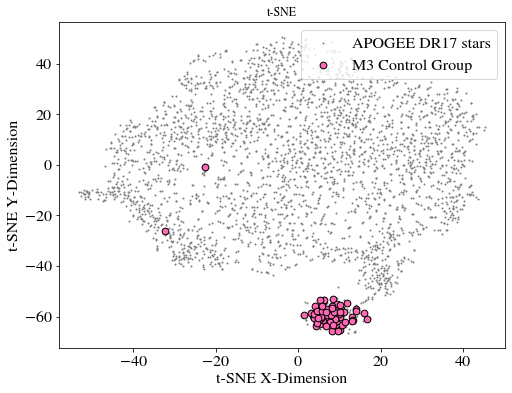

In [93]:
# plotting t-SNE:

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(t_SNE_dimX, t_SNE_dimY, s=1, c='gray', label='APOGEE DR17 stars')
ax.scatter(tsne_dimX_control , tsne_dimY_control, s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
ax.set_xlabel("t-SNE X-Dimension", fontsize=16)
ax.set_ylabel("t-SNE Y-Dimension", fontsize=16)
ax.set_title('t-SNE')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.legend(fontsize=16, loc=1)
plt.show()

## NN:

Now we use the NN to try and reproduce the UMAP data (with the original $19$ chemical abundances as well as radial velocities ($20$ total parameters) as the xs and their corresponding UMAP positions as the ys)

FE_H, C_FE, CI_FE, N_FE, O_FE, MG_FE,
                      AL_FE, SI_FE, P_FE, S_FE, K_FE, CA_FE, 
                      TI_FE, TIII_FE, V_FE, CR_FE, MN_FE, CO_FE,
                       NI_FE, RV in that order

In [84]:
import umap.umap_ as umap

First split the data into training, testing and validation:

In [85]:
# use 70/30 split for training, testing, validation

test_pct = 0.3

# train_pct = 0.6
# valid_pct = 0.2

# seed to use
seed = 1234

reducer = umap.UMAP(n_neighbors=15)
reducer.fit(standardized_array_transpose)

from sklearn.model_selection import train_test_split
# split into training and test
train_xs, test_xs = train_test_split(standardized_array_transpose, test_size = int(test_pct * len(standardized_array_transpose)), random_state=seed)
# train_xs, test_xs, train_ys, test_ys = train_test_split(xs, ys, test_size = int(test_pct * len(xs)), random_state=seed)

Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x7f5d28ed2820>
Traceback (most recent call last):
  File "/usr/lib/python3.8/weakref.py", line 103, in remove
    def remove(wr, selfref=ref(self), _atomic_removal=_remove_dead_weakref):
KeyboardInterrupt: 


Now run UMAP on each of the training and testing sets separately so we have the $y$ values (UMAP outputs):

In [86]:
# training

train_embedding = reducer.transform(train_xs)
train_umap_dimX = train_embedding[:, 0]
train_umap_dimY = train_embedding[:, 1]

# testing

test_embedding = reducer.transform(test_xs)
test_umap_dimX = test_embedding[:, 0]
test_umap_dimY = test_embedding[:, 1]

KeyboardInterrupt: 

Plot the UMAP results:

In [ ]:
# training
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(train_umap_dimX, train_umap_dimY, s=1, label='APOGEE DR17 stars')
ax.set_xlabel("UMAP X-Dimension", fontsize=16)
ax.set_ylabel("UMAP Y-Dimension", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.title('Training')
# testing
fig2, ax2 = plt.subplots(figsize=(8,6))
ax2.scatter(test_umap_dimX, test_umap_dimY, s=1, label='APOGEE DR17 stars')
ax2.set_xlabel("UMAP X-Dimension", fontsize=16)
ax2.set_ylabel("UMAP Y-Dimension", fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='minor', labelsize=16)
plt.title('Testing')

Now create the training and testing ys:

In [ ]:
# ys are the umap positions
train_ys = np.array(list(zip(train_umap_dimX, train_umap_dimY)))
test_ys = np.array(list(zip(test_umap_dimX, test_umap_dimY)))

Now create the model using keras (takes in $20$-D vector and spits out a $2$-D vector):

In [ ]:
import tensorflow as tf

In [ ]:
umap_nn_model = tf.keras.Sequential([
    # tf.keras.layers.InputLayer(batch_input_shape=(batch_size, None, 2))
    tf.keras.layers.Dense(units=100, input_shape=(20, ),  activation='gelu'),
    tf.keras.layers.Dense(units=100, activation='gelu'),
    tf.keras.layers.Dense(units=100, activation='gelu'),
    tf.keras.layers.Dense(units=50, activation='gelu'),
    tf.keras.layers.Dense(units=25, activation='gelu'),
    tf.keras.layers.Dense(units=10, activation='gelu'),
    tf.keras.layers.Dense(units=5, activation='gelu'),
    tf.keras.layers.Dense(units=2)#, activation='gelu')
])

Train the model:

In [ ]:
umap_nn_model.compile(optimizer='adam', 
              loss=tf.losses.MeanSquaredError(),
              metrics=['mse'])

umap_nn_model.fit(train_xs, train_ys, epochs=100)

Test the accuracy:

In [ ]:
test_loss, test_mse = umap_nn_model.evaluate(test_xs, test_ys, verbose=2)
print('\nTest MSE:', test_mse)

Now see the predictions:

In [ ]:
train_preds = umap_nn_model.predict(train_xs)
test_preds = umap_nn_model.predict(test_xs)

In [ ]:
# TRAINING RESULTS
fig = plt.figure(figsize = (12, 8))
plt.scatter(train_preds[:, 0], train_preds[:, 1], s=1, label = 'predicted ys (training)')
plt.scatter(train_ys[:, 0], train_ys[:, 1], s=1, label = 'actual ys (training)')
plt.legend()
plt.title('Training')

# TEST RESULTS (important)
fig2 = plt.figure(figsize = (12, 8))
plt.scatter(test_preds[:, 0], test_preds[:, 1], s=1, label = 'predicted ys (testing)')
plt.scatter(test_ys[:, 0], test_ys[:, 1], s=1, label = 'actual ys (testing)')
plt.legend()
plt.title('Testing')
plt.savefig('test_results.png', fmt='png')

got this working; the actual ys seem a little bit off, although that could jsut be umap being weird

## TUTORIAL:

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Display images

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

Preprocessing:

In [ ]:
def preprocess(x, y):
    x = tf.cast(x, tf.float32) / 255.0  # use the range 0 to 1 for the data
    y = tf.cast(y, tf.int64)  # cast this to int64
    
    return x, y

def create_dataset(xs_data, ys_data, num_classes=10):
    ys_data = tf.one_hot(ys_data, depth=num_classes)
    
    return tf.data.Dataset.from_tensor_slices((xs_data, ys_data)).map(preprocess)

Create dataset:

In [ ]:
train_dataset = create_dataset(train_images, train_labels)
val_dataset = create_dataset(test_images, test_labels)

Create model:

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=192, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=10)
])

In [ ]:
train_dataset

Train model

In [ ]:
model.compile(optimizer='adam', 
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10)

# history = model.fit(
#     train_dataset.repeat(), 
#     epochs=10, 
#     steps_per_epoch=500,
#     validation_data=val_dataset.repeat(), 
#     validation_steps=2
# )

Evaluate accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

See the predictions:

In [ ]:
predictions = tf.keras.Sequential([model, tf.keras.layers.Softmax()]).predict(test_images)
predictions

accuracy:

In [ ]:
np.array([np.argmax(prediction) for prediction in predictions]), test_labels

In [ ]:
np.mean(np.array([np.argmax(prediction) for prediction in predictions]) == test_labels)